In [1]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt

In [2]:
#filename = 't005_alpha_func_phi.npy'
filename = 'v03_alpha_func_phi.npy'
#filename = 'r03_alpha_func_phi.npy'
#filename = 'v005_alpha_func_phi.npy'

raw = np.load(filename)
def Amp_Delta_grid():
    Amp, Delta  = raw[:,1,:],raw[:,0,:]
    alpha  = 0.01*np.arange(10,45)
    phi    = np.linspace(0,1,100,endpoint=False)*2*np.pi
    iAmp   = si.RectBivariateSpline(alpha,phi,Amp)
    iDelta = si.RectBivariateSpline(alpha,phi,Delta)
    return iAmp, iDelta

In [5]:
iAmp,iDelta = Amp_Delta_grid()
def waveform(phi , t , alpha , const_phase, phi0 = 0., tobs = 0.25):
    # t, t0, tobs [s]
    cphi = np.remainder(phi + phi0 , 2*np.pi)
    sort = np.argsort(cphi) # sort the cphi
    rsort = np.argsort(sort) # sort the sort ... to reverse the sort
    Amp = iAmp(alpha,cphi[sort])[0][rsort]
    Delta = iDelta(alpha,cphi[sort])[0][rsort]
    
    freq = alpha/(201160./86400)
    wash_out = np.sin(2*np.pi*freq*tobs/2.)/(2*np.pi*freq*tobs/2.)
    waveform = - wash_out*Amp[None,:]*np.cos(2*np.pi*t[:,None]*freq + cphi[None,:] + Delta[None,:] + const_phase)
    
    return waveform


def gen_calc_norm_chisq(varphi5,sig5,varphi11,sig11):
    
    def calc_norm_chisq(alpha,phi0):
        evpa1 = waveform(varphi5 , np.array([6,5]) , alpha , phi0)*57.3
        evpa2 = waveform(varphi11 , np.array([11,10]) , alpha , phi0)*57.3

        devpa1 = np.diff(evpa1,axis=0)
        devpa2 = np.diff(evpa2,axis=0)

        chisq1 = np.sum(devpa1**2/sig5**2)
        chisq2 = np.sum(devpa2**2/sig11**2)
        chisq_norm = chisq1 + chisq2

        return chisq_norm
    
    return np.vectorize(calc_norm_chisq)


def ipgen(lnlike_xy):
    
    z_list = np.linspace(0,lnlike_xy.max(),200)
    lnlike_msk = (lnlike_xy[:,:,None]<=z_list[None,None,:])*lnlike_xy[:,:,None]
    int_prob_list = lnlike_msk.sum(axis=0).sum(axis=0)
    
    ip = lambda int_prob:np.interp(int_prob*int_prob_list.max(),int_prob_list,z_list)
    return ip
    
def quantile95(lnlike_xy ,ylist ):
    
    xlist = np.arange(100)
    ylist = ylist
    int_prob_list = np.cumsum(lnlike_xy,axis=1)
    maxvals = np.max(int_prob_list,axis=1)
    int_prob_list2 = int_prob_list/maxvals[:,None]
    uls = []
    for i in range(len(xlist)):
        ul = np.interp(0.95,int_prob_list2[i,:] ,ylist)
        uls.append(ul)
    
    
    return np.array(uls)

In [6]:
phi = np.linspace(0,2*np.pi,200,endpoint=False)
t = np.array([5.,6.,10.,11.])
#t = np.array([5.,11.])

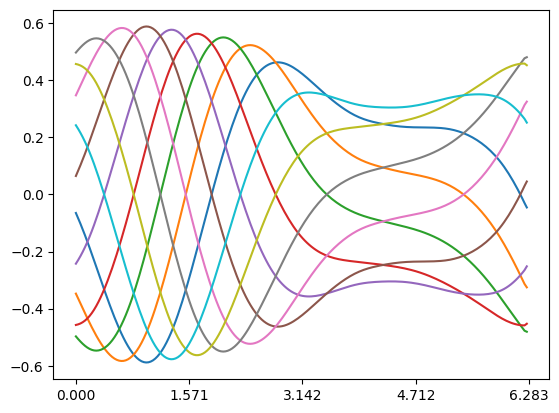

In [7]:
for i in np.arange(10):
    out = waveform( phi , t , 0.4 , i/10*2*np.pi )
    plt.plot(phi,out[3])
#colors = ['r','r--','k','k--']
plt.xticks([0,np.pi/2,np.pi,np.pi*3/2,2*np.pi]);

#plt.plot(phi,out[3]-out[2],'k--')

# Data

In [9]:
alphas = np.linspace(0.1,0.45,100)
phis = np.linspace(0,1,80,endpoint=False)*2*np.pi
alpha_mesh,phi_mesh = np.meshgrid(alphas,phis,indexing='ij')
c = np.logspace(np.log10(1/137),3,90)
#ga = np.logspace(-3,3,90)/2/np.pi
ga = c/2/np.pi
def calculate_ul95_with_data(source):

    data5 = np.loadtxt('all_data/'+source+'/'+source+'_sigma_5th.csv',delimiter=',').T
    data11 = np.loadtxt('all_data/'+source+'/'+source+'_sigma_11th.csv',delimiter=',').T
    varphi5,sig5 = data5[0],data5[3]
    varphi11,sig11 = data11[0],data11[3]

    #data5 = np.loadtxt('DMC_sigma_5th.csv',delimiter=',').T
    #data11 = np.loadtxt('DMC_sigma_11th.csv',delimiter=',').T
    #varphi5,sig5 = data5[0],np.abs(data5[3])
    #varphi11,sig11 = data11[0],np.abs(data11[3])

    varphi5 = (varphi5-18.)/360*2*np.pi
    varphi11 = (varphi11-18.)/360*2*np.pi
    sig5 = sig5*np.sqrt(2)
    sig11 = sig11*np.sqrt(2)
    
    
    #ga = np.linspace(1e-20,1,200)/2/np.pi


    
    
    # Calculating Chisq
    calc_norm_chisq = gen_calc_norm_chisq(varphi5,sig5,varphi11,sig11)
    norm_chisq = calc_norm_chisq(alpha_mesh,phi_mesh)
    
    chisq = norm_chisq[:,:,None]*ga**2
    
    lnlike = np.exp(-chisq/2)
    _lnlike_xy = lnlike.mean(axis=1)
    lnlike_xy = _lnlike_xy
    
    ul95 = 10**quantile95(lnlike_xy,ylist = np.log10(ga))*2*np.pi
    
    return ul95

# NGEHT

In [12]:
rawR = np.genfromtxt('NormR.csv',delimiter=',')
normR = rawR[:,2].reshape(38,490)
alpha_list = rawR[:,0].reshape(38,490)
rlist = rawR[:,1].reshape(38,490)

#[alpha, R]

factor_new = np.interp(alphas,alpha_list[:,0], np.sqrt((normR[:,[34,44,54,64,74]]**2).sum(axis=1)/5))
factor_45 = np.interp(alphas,alpha_list[:,0], normR[:,34])
factor_old = np.interp(alphas,alpha_list[:,0], normR[:,59])
factor_5 = np.interp(alphas,alpha_list[:,0], normR[:,39])

#ul_ngeht = 3/180*np.pi*2*np.pi/factor_new/np.sqrt(3000)
ul_ngeht = 3/180*np.pi*2*np.pi/factor_new/np.sqrt(3000)

#ul_ngeht = 

In [13]:
try:
    uldict
except:
    uldict={}
    

for source in ['polsolve']:
    amass = alphas*2.05591e-20
    _x,_y = np.meshgrid(np.log10(amass),np.log10(ga*2*np.pi),indexing='ij')
    ul95 = calculate_ul95_with_data(source)
    uldict.update({source:ul95})


# Contour

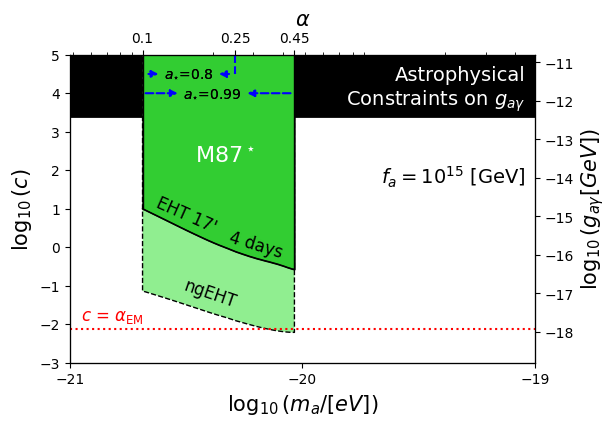

In [15]:

fig,ax = plt.subplots(figsize=(6,4))
plt.xlabel('$\log_{10}(m_a/[eV])$',size=15)
plt.ylabel(r'$\log_{10}(c)$',size=15)




#Other Limits
plt.fill_between([-22,-14],[np.log10(8e-13/2*1e15*2*np.pi)]*2,[8,8],ls='-',lw=2,fc='black',alpha=1,ec='black')
plt.annotate('Astrophysical'+'\n Constraints on $g_{a\gamma}$',xy=(0.98,0.81),xycoords='axes fraction',color='white',ha='right',va='bottom',size=14)




#the UL
#divede into two parts

ul95 = uldict['polsolve']
plt.fill_between(np.log10(amass),np.log10(ul_ngeht),8,ls='--',lw=1,ec='k',fc='lightgreen',alpha=1)
plt.fill_between(np.log10(amass[:]),np.log10(ul95[:]),8,ls='-',lw=1,ec='k',fc='limegreen',alpha=1)
#plt.plot(np.log10([amass[midindex],amass[midindex]]),[np.log10(ul95[midindex]),6],color='k',ls='-' )
#plt.plot(np.log10([amass[-1],amass[-1]]),[np.log10(ul95[-1]),6],color='k',ls='--' )



'''
Make the border clearer!!!
'''
plt.plot([np.log10(amass[0])]*2,[np.log10(ul95[0]),6],'k',lw=1)
plt.plot([np.log10(amass[-1])]*2,[np.log10(ul95[-1]),6],'k',lw=1)
plt.plot(np.log10(amass[:]),np.log10(ul95[:]),'k',ls='-',lw=1)


plt.annotate(r'M87$^\star$',xy=(0.27,0.65),xycoords='axes fraction',color='white',ha='left',size=16)
plt.annotate('EHT 17\'',xy=(-20.64,0.28),va='bottom',ha='left',rotation=-24,size=12)
plt.annotate('4 days',xy=(-20.322,-0.37),va='bottom',ha='left',rotation=-17,size=12)
plt.annotate('ngEHT',xy=(-20.52,-1.65),va='bottom',ha='left',rotation=-19,size=12)

#plt.plot(np.log10(amass),np.log10(ga[z1]*2*np.pi),'r',label='$1\sigma$')
#plt.plot(np.log10(amass),np.log10(ga[z2]*2*np.pi),'orange',label='$2\sigma$')

logcmin = -3
logcmax = 5
fa = 1e15
loggmin = logcmin - np.log10(2*np.pi*fa)
loggmax = logcmax - np.log10(2*np.pi*fa)
plt.xlim(-21,-19)
plt.ylim(logcmin,logcmax)
plt.xticks([-21,-20,-19])
plt.plot([-21,-19],[np.log10(1/137),np.log10(1/137)],color='red',ls=':')
plt.annotate(r'$c$ = $\alpha_{\rm EM}$',xy=(-21+0.05,np.log10(1/137)+0.1),ha='left',va='bottom',size=12,color='red')


#fa
plt.annotate('$f_a=10^{15}$ [GeV]',xy=(0.98,0.58),xycoords='axes fraction',ha='right',size=14)





#alpha
ax2 = ax.twiny()



ax2.set_xlim(1e-21/2.05591e-20    ,   1e-19/2.05591e-20)
ax2.set_xscale('log')
ax2.set_xticks([0.1,0.25,0.45]);
ax2.set_xticklabels([0.1,0.25,0.45]);
ax2.set_xlabel(r'$\alpha$',size=15)
#plt.title(source)
ax2.annotate(r'$a_{\star}$=0.99', xy=(0.1, 4), xytext=(0.2, 4),va='center',ha='center', arrowprops=dict(arrowstyle='<|-',ls='--',lw=1.5, color='blue'))
ax2.annotate(r'$a_{\star}$=0.99', xy=(0.45, 4), xytext=(0.2, 4),va='center',ha='center', arrowprops=dict(arrowstyle='<|-',ls='--',lw=1.5, color='blue'))
ax2.annotate(r'$a_{\star}$=0.8', xy=(0.1, 4.5), xytext=(0.158, 4.5),va='center',ha='center', arrowprops=dict(arrowstyle='<|-',ls='--', lw=1.5,color='blue'))
ax2.annotate(r'$a_{\star}$=0.8', xy=(0.25, 4.5), xytext=(0.158, 4.5),va='center',ha='center', arrowprops=dict(arrowstyle='<|-',ls='--', lw=1.5,color='blue'))
ax2.plot([0.25,0.25],[4.5,5],ls='--',color='blue')

ax3 = ax.twinx()
ax3.set_ylim(loggmin,loggmax)
ax3.set_ylabel(r'$\log_{10}(g_{a\gamma} [GeV])$',size=15)


plt.savefig('ul.pdf',bbox_inches='tight')


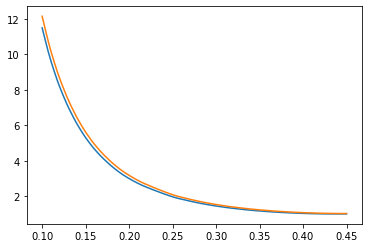

In [11]:


plt.plot(alphas,1/factor_old)
plt.plot(alphas,1/factor_new)